In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
tweet_df = pd.read_csv("Tweet_data.csv", encoding='utf-8', header=None)
tweet_df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
tweet_df.columns = ['target','id','date','flag','user','text']

In [4]:
tweet_df = tweet_df.drop(['id','date','flag','user'], axis=1)
tweet_df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
tweet_df.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [6]:
from numpy.random import RandomState

rng = RandomState()

train_df = tweet_df.sample(frac=0.8, random_state=rng)
val_df = tweet_df.loc[~tweet_df.index.isin(train_df.index)]

In [7]:
train_df.target.value_counts()

4    640168
0    639832
Name: target, dtype: int64

In [8]:
val_df.target.value_counts()

0    160168
4    159832
Name: target, dtype: int64

In [9]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()

len(train_sentences), len(val_sentences)

(1280000, 320000)

In [10]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())

train_labels_encoded

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(
    X=train_sentences,
    y=train_labels_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [13]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.772134375

In [14]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    model_results = {'accuracy':model_accuracy,
                    'precision':model_precision,
                    'recall':model_recall,
                    'f1-score':model_f1}
    return model_results

In [16]:
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 0.772134375,
 'precision': 0.7744264534253559,
 'recall': 0.772134375,
 'f1-score': 0.7716420393787706}

In [17]:
#Model-1

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.round(np.mean(sent_lens))
avg_sent_len

13.0

(array([1.85584e+05, 2.81768e+05, 2.49395e+05, 1.98401e+05, 1.64298e+05,
        1.62382e+05, 3.62340e+04, 1.90700e+03, 2.30000e+01, 4.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([ 1. ,  5.2,  9.4, 13.6, 17.8, 22. , 26.2, 30.4, 34.6, 38.8, 43. ,
        47.2, 51.4, 55.6, 59.8, 64. ]),
 <BarContainer object of 15 artists>)

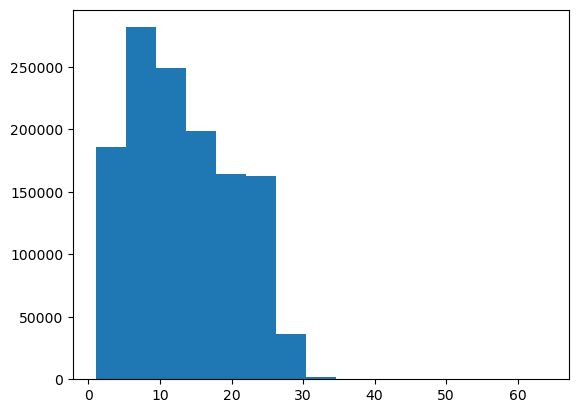

In [18]:
plt.hist(sent_lens, bins=15)

In [19]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

25

In [20]:
max_tokens = 60000

text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len,
    pad_to_max_tokens=True
)

In [21]:
text_vectorizer.adapt(train_sentences)

In [22]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 @forevermoving I also want  Bring me okay. Hahahaha

Length of text: 51

Vectorized text: [[   1    2  262   70  565   16  352 1288    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


In [23]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 60000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 25,
 'pad_to_max_tokens': True}

In [24]:
token_embed = tf.keras.layers.Embedding(
    input_dim = 60000,
    output_dim = 128,
    mask_zero = True,
    name='token_embedding'
)

In [25]:
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}")
print(f"Vectorized sentence shape: {vectorized_sentence.shape}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 @forevermoving I also want  Bring me okay. Hahahaha

Sentence after vectorization (before embedding):
 [[   1    2  262   70  565   16  352 1288    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
Vectorized sentence shape: (1, 25)
Sentence after embedding:
 [[[-3.2270171e-02  4.2926185e-03  4.4887487e-02 ...  3.7129853e-02
   -4.7812283e-02  2.5982205e-02]
  [ 1.0785829e-02  4.1601028e-02 -3.9170146e-02 ...  4.8626367e-02
   -4.4218756e-02  3.0960891e-02]
  [ 1.3158027e-02 -4.6567846e-02 -9.4629824e-05 ... -2.8569127e-02
   -3.3703931e-03 -4.6705067e-02]
  ...
  [-4.6010163e-02 -2.8332114e-02  1.2640450e-02 ... -1.3332479e-03
   -4.5008771e-03 -4.2562261e-03]
  [-4.6010163e-02 -2.8332114e-02  1.2640450e-02 ... -1.3332479e-03
   -4.5008771e-03 -4.2562261e-03]
  [-4.6010163e-02 -2.8332114e-02  1.2640450e-02 ... -1.3332479e-03
   -4.5008771e-03 -4.2562261e-03]]]

Embedded sentence shape: (1, 25, 128)


In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

In [27]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [28]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
model_1 = tf.keras.Model(inputs,outputs,name='model_1_Conv1D_Token')

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_1_history = model_1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    steps_per_epoch=int(0.1*len(train_dataset)),
    validation_steps=int(0.1*len(val_dataset))
)

Epoch 1/3
4000/4000 [==============================] - 90s 21ms/step - loss: 0.4945 - accuracy: 0.7648 - val_loss: 0.4406 - val_accuracy: 0.7805
Epoch 2/3
3005/4000 [=====================>........] - ETA: 19s - loss: 0.4614 - accuracy: 0.7880

In [ ]:
model_1.evaluate(val_dataset)

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

In [ ]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

In [ ]:
baseline_results

In [ ]:
#----Models----
#1 - Naive Bayes with TF-IDF encoder
#2 - Conv1D with token embeddings
#3 - TensorFlow Hub Pretrained Feature Extractor
#4 - Conv1D with character embeddings
#5 - Pretrained token embeddings (same as 2) + character embeddings (same as 3)
#6 - Pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
import tensorflow_hub as hub

uni_sentence_encoder = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                     name='uni_sentence_encoder')

In [ ]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = uni_sentence_encoder([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = uni_sentence_encoder(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(2, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE')

In [ ]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_2_history = model_2.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=3,
    validation_steps=int(0.1*len(val_dataset)),
    steps_per_epoch=int(0.1*len(train_dataset))
)

In [ ]:
model_2.evaluate(val_dataset)

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

In [ ]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

In [ ]:
baseline_results

In [ ]:
#Model-3 - Character Embedding

def split_chars(text):
    return " ".join(list(text))

In [ ]:
split_chars(random_train_sentence)

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

print(train_chars[:5])

In [ ]:
chars_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_len)
mean_char_len

In [ ]:
plt.hist(chars_len, bins=15)

In [ ]:
output_seq_char_len = int(np.percentile(chars_len, 95))
output_seq_char_len

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

In [ ]:
NUM_CHAR_TOKENS = len(alphabet)
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    name='char_vectorizer'
)

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"Vectorized chars shape: {vectorized_chars.shape}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

In [ ]:
char_embed = tf.keras.layers.Embedding(
    input_dim=len(char_vocab),
    output_dim=25,
    mask_zero=True,
    name='char_embed'
)

In [ ]:
print(f"Charified text: {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedd chars:\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

In [ ]:
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_Conv1D_Char')

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_3_history = model_3.fit(
    train_dataset,
    epochs=3,
    validation_data=val_dataset,
    steps_per_epoch=int(0.1* len(train_dataset)),
    validation_steps=int(0.1*len(val_dataset))
)

In [ ]:
model_3.evaluate(val_dataset)

In [ ]:
model_3_pred_probs = model_3.predict(val_dataset)
model_3_pred_probs

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

In [ ]:
#Pretrained token embeddings with character embeddings

token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = uni_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

token_char_concat = tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(2, activation='softmax')(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name='model_4_token_and_char_embeddings')


In [ ]:
model_4.summary()

In [ ]:
model_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
train_labels_one_hot.shape

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

In [ ]:
model_4_history = model_4.fit(
    train_char_token_dataset,
    steps_per_epoch=int(0.1*len(train_char_token_dataset)),
    epochs=3,
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1*len(val_char_token_dataset))
)

In [ ]:
model_4.evaluate(val_char_token_dataset)

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

In [ ]:
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

In [ ]:
#Model-5

train_df.head()

In [ ]:
train_sentences[:5]

In [ ]:
total_line = [len(word.split()) for word in train_sentences]
total_line

train_df['total_line'] = total_line
val_df['total_line'] = [len(word.split()) for word in val_sentences]

train_df['line_number'] = [word for word in enumerate(train_sentences)]
train_df.head()

In [ ]:
train_df['total_line'].value_counts()

In [ ]:
train_df.total_line.plot.hist()

In [ ]:
np.percentile(train_df.total_line, 98)

In [ ]:
train_total_line_one_hot = tf.one_hot(train_df['total_line'].to_numpy(), depth=27)
val_total_line_one_hot = tf.one_hot(val_df['total_line'].to_numpy(), depth=27)

In [ ]:
#Create a token-level model
#Create a character-level model
#Create a model for the line number feature
#Create a model for the total lines feature
#Combine the outputs of the first two models using concatenate
#Combine the features and the combined models using concatenate

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = uni_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

total_lines_inputs = layers.Input(shape=(20), dtype=tf.float32, name='total_line_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)

combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output, char_model.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output, total_line_model.output, z])

output_layer = layers.Dense(2, activation='softmax')(tribrid_embeddings)

model_5 = tf.keras.Model([line_number_model.input,
                         total_line_model.input,
                         token_model.input,
                         char_model.input], outputs=output_layer)

In [ ]:
model_5.summary()

In [ ]:
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
#Create training and validation datasets using all four sets of data

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                               train_total_line_one_hot,
                                                               train_sentences,
                                                               train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                               val_total_line_one_hot,
                                                               val_sentences,
                                                               val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)